In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv('daraz.csv')

In [ ]:
data['Sentiments'] = data['Sentiments'].str.lower()

In [ ]:
sentiment_counts = data['Sentiments'].value_counts()
print("Sentiment Category Report:")
print(sentiment_counts)

Sentiment Category Report:
Sentiments
positive    4694
negative    2635
neutral     1478
Name: count, dtype: int64


<ipython-input-41-c4b922968feb>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


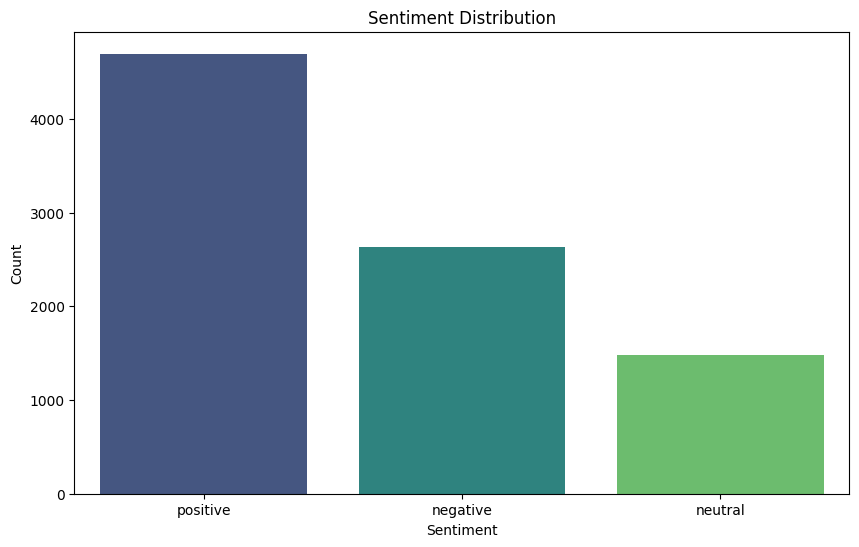

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

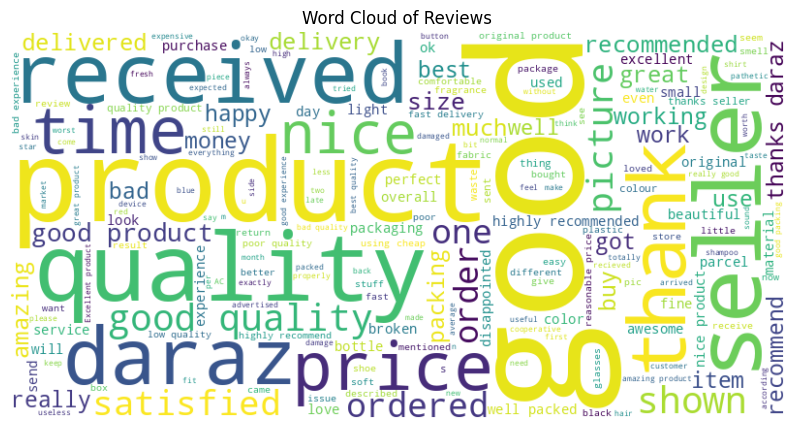

In [ ]:
from wordcloud import WordCloud

text = " ".join(data["Reviews"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Reviews")
plt.show()

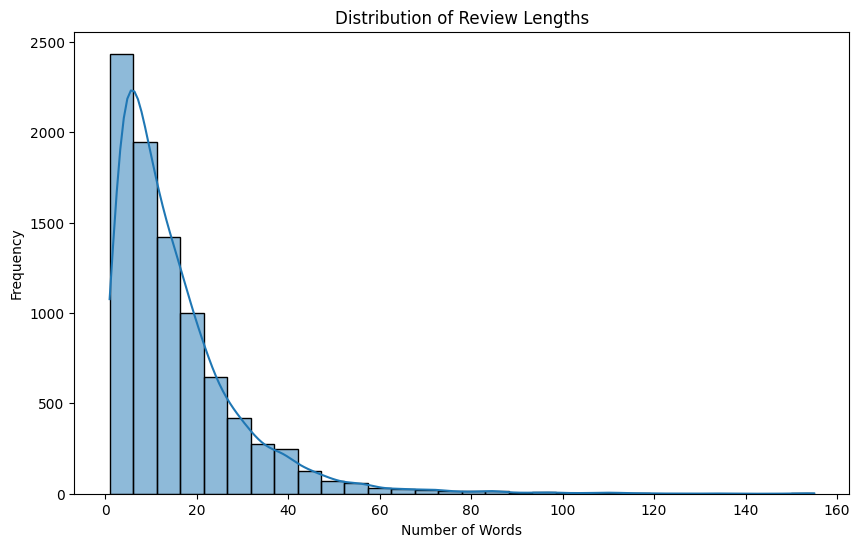

In [ ]:
review_lengths = data["Reviews"].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(review_lengths, bins=30, kde=True)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [ ]:
import nltk
nltk.download('punkt')
import re
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s\d]+', '', text)
    text = re.sub(r'\d+', '', text)
    words = nltk.word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

data['Reviews'] = data['Reviews'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
data.to_csv('raw_dataset.csv', index=False)

In [ ]:
raw_dataset_info = """
Raw Dataset Information:
- Source: daraz.csv
- Number of instances: {}
- Number of features: {}
- Target variable: Sentiments
- Description: This dataset contains customer reviews from daraz.com with sentiment labels.
""".format(len(data), data.shape[1])
with open('raw_dataset_info.txt', 'w') as f:
    f.write(raw_dataset_info)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data["Reviews"], data["Sentiments"], test_size=0.2, random_state=42
)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(set(data["Sentiments"]))
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convert target labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
import torch

train_labels = torch.tensor(y_train_encoded, dtype=torch.long)
test_labels = torch.tensor(y_test_encoded, dtype=torch.long)

In [ ]:
max_length = 128  # Define maximum sequence length
train_encodings = tokenizer(
    list(X_train.values), truncation=True, padding=True, max_length=max_length
)
test_encodings = tokenizer(
    list(X_test.values), truncation=True, padding=True, max_length=max_length
)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Create PyTorch datasets
train_dataset = TensorDataset(
    torch.tensor(train_encodings["input_ids"]),
    torch.tensor(train_encodings["attention_mask"]),
    train_labels,
)
test_dataset = TensorDataset(
    torch.tensor(test_encodings["input_ids"]),
    torch.tensor(test_encodings["attention_mask"]),
    test_labels,
)

In [ ]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
device = torch.device("cuda")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [ ]:
num_epochs = 3
train_loss_values = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = (
            input_ids.to(device),
            attention_mask.to(device),
            labels.to(device),
        )
        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids, attention_mask=attention_mask, labels=labels
        )
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    scheduler.step()
    avg_train_loss = total_loss / len(train_loader)
    train_loss_values.append(avg_train_loss)
    print(
        f"Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {avg_train_loss:.4f}"
    )

Epoch 1/3, Average Training Loss: 0.4552
Epoch 2/3, Average Training Loss: 0.2379
Epoch 3/3, Average Training Loss: 0.1953


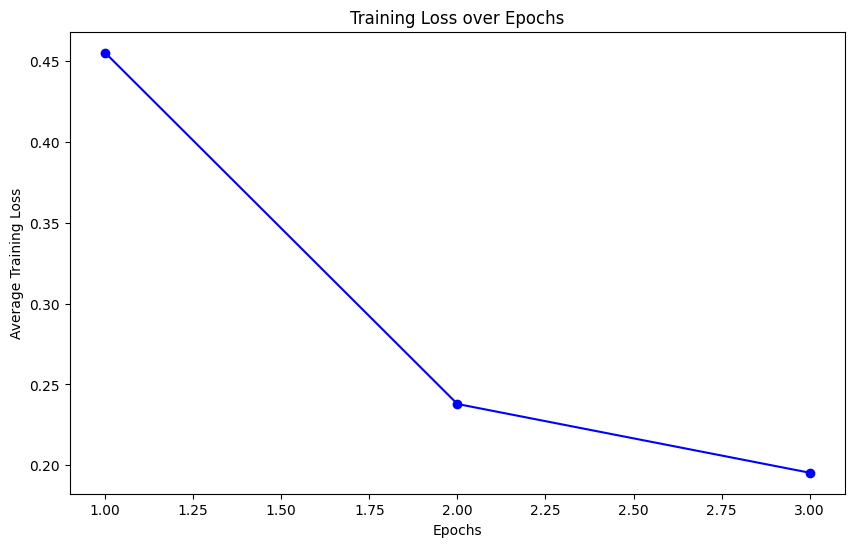

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, num_epochs + 1), train_loss_values, marker="o", linestyle="-", color="b"
)
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Average Training Loss")
plt.show()

In [ ]:
model.eval()
logits = []
true_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = (
            input_ids.to(device),
            attention_mask.to(device),
            labels.to(device),
        )
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits.extend(outputs.logits.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [ ]:
# Convert logits to probabilities
logits = np.array(logits)
y_probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

In [ ]:
from sklearn.metrics import average_precision_score

# One-vs-rest approach for precision-recall and ROC curves
n_classes = len(label_encoder.classes_)
precision = dict()
recall = dict()
average_precision = dict()
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(np.array(true_labels) == i, y_probs[:, i])
    average_precision[i] = average_precision_score(np.array(true_labels) == i, y_probs[:, i])
    fpr[i], tpr[i], _ = roc_curve(np.array(true_labels) == i, y_probs[:, i])
    roc_auc[i] = roc_auc_score(np.array(true_labels) == i, y_probs[:, i])

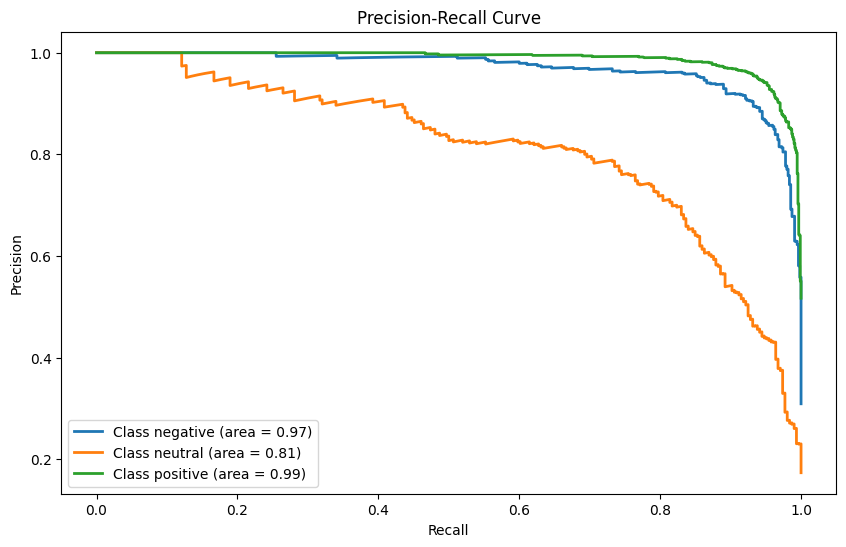

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label='Class {0} (area = {1:0.2f})'.format(label_encoder.classes_[i], average_precision[i]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
)

accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average="weighted")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Accuracy: 0.9052213393870602
F1 Score: 0.9042631170578255


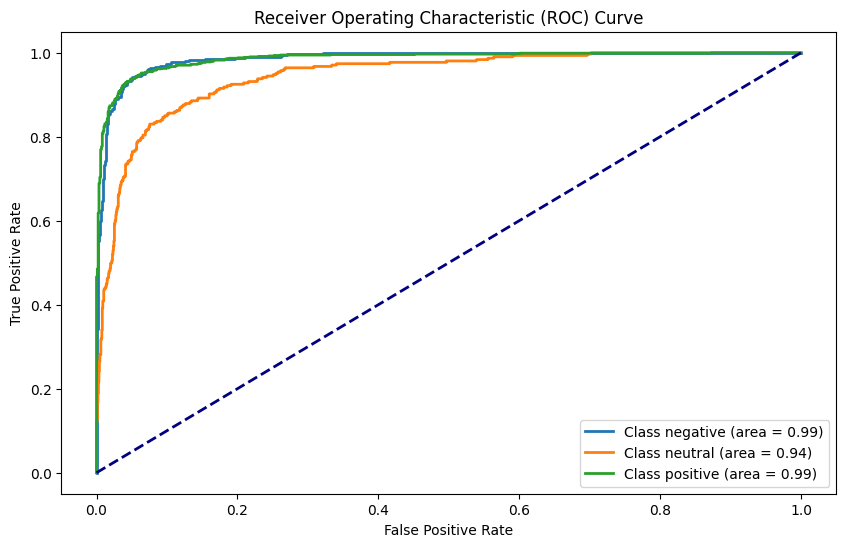

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {0} (area = {1:0.2f})'.format(label_encoder.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="best")
plt.show()

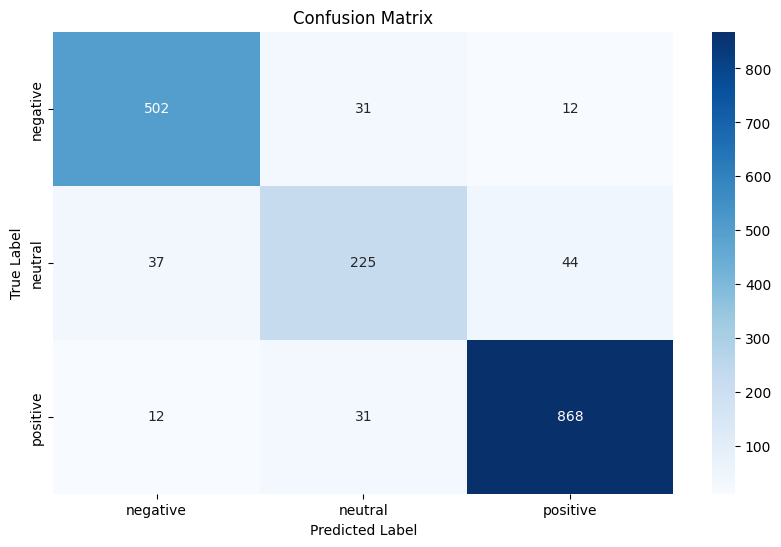

In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

class_report = classification_report(
    true_labels, predictions, target_names=label_encoder.classes_
)
print(class_report)

              precision    recall  f1-score   support

    negative       0.91      0.92      0.92       545
     neutral       0.78      0.74      0.76       306
    positive       0.94      0.95      0.95       911

    accuracy                           0.91      1762
   macro avg       0.88      0.87      0.87      1762
weighted avg       0.90      0.91      0.90      1762

